In [ ]:
import sys
import os
import yaml


sys.path.insert(1, "/Volumes/EeroQ/lib/zeroheliumkit-dev/") 
import numpy as np
from math import pi

from shapely import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from shapely import affinity, intersects, line_merge, box, intersection
import shapely.affinity as aff
import copy

import matplotlib
from zeroheliumkit import GeomCollection, SpiralInductor
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_DXF, Reader_GDS, Reader_Pickle


%matplotlib widget
%config InlineBackend.figure_format='retina'

from zeroheliumkit import Structure, Entity, Anchor, SuperStructure, GeomCollection, Taper, MultiAnchor, ArbitraryLine, Skeletone
from zeroheliumkit import Rectangle, Meander, MeanderHalf, Square, StraightLine, Circle, ArcLine
from zeroheliumkit.src.utils import midpoint, round_polygon
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_Pickle
from zeroheliumkit.helpers.resonator_calc import CPW_params

sys.path.append('C:\\Users\\gageg\\source\\repos\\zeroheliumkit')



  

In [3]:

# Utility functions for anchor management
def clearAnchors(object):
    """Remove all anchors from an object"""
    for anc in object.anchors.labels:
        object.remove_anchor(anc)

def remakeAnchor(object: Structure, AnchorName: str, position: tuple, direction: float):
    """Create or recreate an anchor with specified parameters"""
    if object.get_anchor(AnchorName) is None:
        object.add_anchor(Anchor(position, direction, AnchorName))
    else:
        object.remove_anchor(AnchorName)
        object.add_anchor(Anchor(position, direction, AnchorName))

class FourPointProbe(Structure):
    """
    Creates a four-point probe structure for electrical measurements.
    
    This class generates a complete four-point probe structure with pads and connectors
    for electrical characterization of thin films.
    
    Args:
        length (float): The length of the film being tested (x axis)
        width (float): The thickness of the film being tested (y axis)
        connector_thickness (float): The thickness of the probe electrodes
        layers (dict): Dictionary containing the names and widths of the layers
        alabel (tuple, optional): Tuple containing the labels for the anchors
        pad_size (float, optional): Size of the contact pads. Defaults to 200
    """
    def __init__(self,
                length: float,
                width: float,
                layers: dict,
                connector_width: float = 50,
                alabel: tuple=("z1",),
                pad_size: float = 200):
        super().__init__()
        
        # Store instance parameters
        self.length = length
        self.width = width
        self.pad_size = pad_size
        self.layer_thicknesses = layers
        self.layers = list(layers.keys())
        self.connector_width = connector_width
        self.alabel = alabel

        # Build the probe structure
        self._create_quarter_probe()
        self._create_full_probe()
        
        # Setup anchors
        clearAnchors(self)
        
        # Add main anchor
        if self.alabel is None or not self.alabel:
            self.add_anchor(Anchor((0, 0), 0, "probe_origin"))
        else:
            self.add_anchor(Anchor((0, 0), 0, self.alabel[0]))
            
    def _create_quarter_probe(self):
        """Creates a quarter of the probe structure as a building block"""
        quarter = Structure()
        
        # Create and configure pad
        pad = Structure()
        pad.add_layer("top", round_polygon(Square(self.pad_size), 40))
        pad.add_anchor(Anchor((0, -self.width/2), 0, "o"))
        pad.add_anchor(Anchor((0, 0), 90, "tm"))
        
        # Create taper between pad and connector
        taper_info = {
            "top": (self.pad_size-80, self.connector_width)
        }
        taper = Taper(self.pad_size, taper_info, alabel=("a1", "a2"))
        
        # Create main test structure
        test_struct = Structure()
        test_struct.add_layer("top", Rectangle(self.length/2, self.width/2))
        test_struct.add_anchor(Anchor((-self.length/4, -self.width/4), 0, "bottom_left"))
        test_struct.add_anchor(Anchor((self.length/4, self.width/4), 0, "top_right"))
        test_struct.add_anchor(Anchor((-self.length/4 + self.connector_width/2, -self.width/4), 0, "attach_point"))
        
        # Assemble quarter probe components
        quarter.add_anchor(Anchor((0, 0), 0, "origin"))
        quarter.add_anchor(Anchor((500-self.length/2, 725), 0, "test_loc"))
        quarter.append(pad, anchoring=("origin", "o"), direction_snap=True, remove_anchor="o")
        quarter.append(taper, anchoring=("tm", "a1"), direction_snap=True, remove_anchor="a1")
        quarter.append(test_struct, anchoring=("test_loc", "bottom_left"), direction_snap=True, remove_anchor="bottom_left")
        
        # Add connector between components
        top_right_coord = quarter.get_anchor("top_right").coords
        c1 = Anchor(quarter.get_anchor("a2").coords, 90, "c1")
        c2 = Anchor(quarter.get_anchor("attach_point").coords, 90, "c2")
        connector = StraightLine((c1, c2), layers=self.layer_thicknesses, alabel=("c1", "c2"))
        connector.buffer_line("top", self.connector_width/2)
        quarter.append(connector, anchoring=("a2", "c1"), remove_anchor="c1")
        
        # Clean up and finalize anchors
        clearAnchors(quarter)
        remakeAnchor(quarter, "top_right", top_right_coord, 0)

        self.quarter_probe = quarter
        
    def _create_full_probe(self):
        """Creates the full four-point probe by mirroring the quarter probe"""
        # Create half probe
        half = Structure()
        
        # Create temporary anchors with unique names
        temp_origin_name = f"temp_origin_{self.alabel[0]}" if self.alabel else "origin2"
        half.add_anchor(Anchor((0, 0), 0, temp_origin_name))
        
        # Build half probe from quarter sections
        half.append(self.quarter_probe, anchoring=(temp_origin_name, "top_right"), direction_snap=True, remove_anchor="top_right")
        half.append(self.quarter_probe.return_mirrored("x"), anchoring=(temp_origin_name, "top_right"), direction_snap=True, remove_anchor="top_right")
        
        # Create full probe
        temp_true_o = f"temp_true_o_{self.alabel[0]}" if self.alabel else "true_o"
        self.add_anchor(Anchor((0, 0), 0, temp_true_o))
        
        # Assemble full probe
        self.append(half, anchoring=(temp_true_o, temp_origin_name), direction_snap=False, remove_anchor=temp_origin_name)
        self.append(half.return_mirrored("y"), anchoring=(temp_true_o, temp_origin_name), direction_snap=False, remove_anchor=temp_origin_name)
        
        # Clean up temporary anchors
        if self.get_anchor(temp_true_o):
            self.remove_anchor(temp_true_o)

    def plot(self, config=None):
        """
        Plot the four-point probe structure
        
        Args:
            config (dict, optional): Dictionary of plotting configurations. If None,
                                   uses default color scheme
        """
        if config is None:
            config = {
                "wafer": LIGHTGRAY,
                "bottom": YELLOW2,
                "gnd": BLUE,
                "etch": VIOLET,
                "top": ORANGE,
                "open": GREEN,
                "air": (GRAY, 0.7),
                "skeletone": DARKGRAY,
                "anchors": RED
            }
        self.quickplot(config)



(-3250.0, 500.0, 0)
(-2500.0, 750.0, -90)
(-1500.0, 750.0, -90)
(-500.0, 750.0, -90)
(500.0, 750.0, -90)
(1500.0, 750.0, -90)
(2500.0, 750.0, -90)
(3250.0, 500.0, 180)
(3250.0, -500.0, 180)
(2500.0, -750.0, 90)
(1500.0, -750.0, 90)
(500.0, -750.0, 90)
(-500.0, -750.0, 90)
(-1500.0, -750.0, 90)
(-2500.0, -750.0, 90)
(-3250.0, -500.0, 0)
Geometries saved successfully.


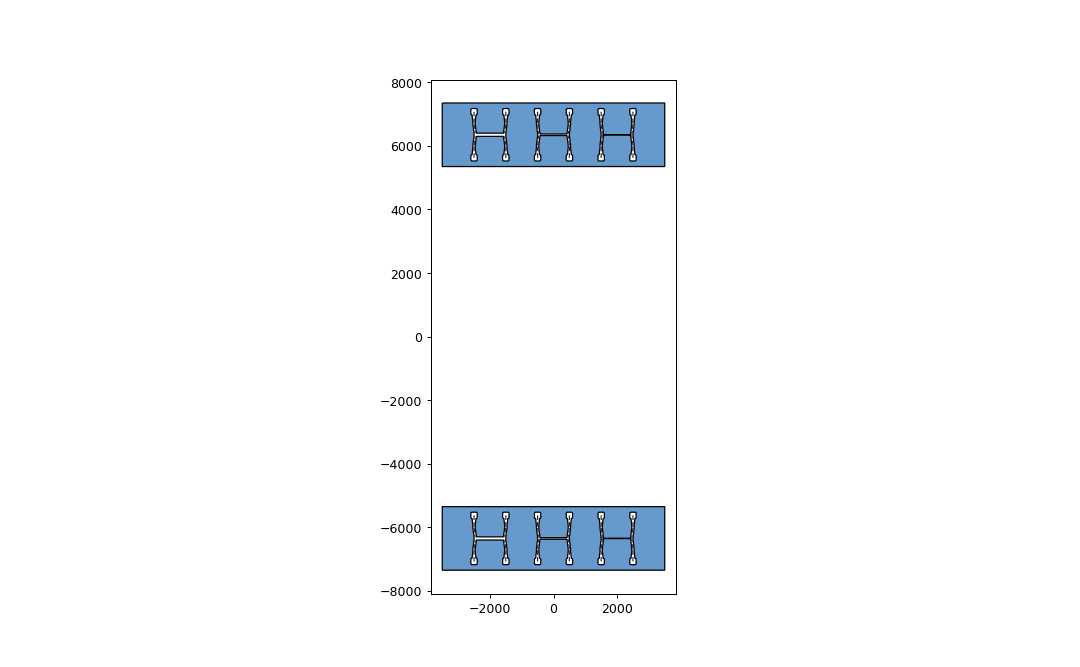

In [15]:


# Example usage and configuration
if __name__ == "__main__":
    # Define plotting configuration
    plot_config = {
        "wafer": LIGHTGRAY,
        "bottom": YELLOW2,
        "gnd": BLUE,
        "top": ORANGE,
        "etch": VIOLET,
        "open": GREEN,
        "air": (GRAY, 0.7),
        "skeletone": DARKGRAY,
        "anchors": RED
    }

    # Define routing configuration
    route_config = {"radius": 100, "num_segments": 51}

    # Setup geometric parameters
    circle_radius = 50800
    pad_size = 200
    
    # Create quarter wafer structure
    quarter_wafer = SuperStructure(route_config)
    quarter_wafer.add_anchor(Anchor((0, 0), 0, "c"))

    # Setup pad and chip dimensions
    inch = 25400
    Lx = 7000
    Ly1 = 2*7350
    Ly2 = 2*5350
    spacing = 1000
    offset = 250

    # Create and configure chip
    chip = SuperStructure(plot_config)
    # chip.add_layer("bottom", Square(inch))
    chip.add_layer("gnd",Rectangle(Lx,Ly1,(0,0)))
    chip.add_layer("etch",Rectangle(Lx,Ly2,(0,0)))

    # Setup pad coordinates
    coords_t = [(-Lx/2 + offset, spacing/2, 0)] + \
              [(-spacing*5/2 + spacing*i, Ly/2 - offset, -90) for i in range(6)] + \
              [(Lx/2 - offset, spacing/2, 180)]

    coords_d = [(Lx/2 - offset, -spacing/2, 180)] + \
              [(spacing*5/2 - spacing*i, -Ly/2 + offset, 90) for i in range(6)] + \
              [(-Lx/2 + offset, -spacing/2, 0)]

    # Add pads to chip
    for i, coord in enumerate(coords_t + coords_d):
        x, y, angle = coord
        print(coord)
        chip.add_anchor(Anchor((x, y), angle, f"p{i}"))

    # Create pad structure
    pad = Structure()
    pad.add_layer("top", round_polygon(Square(pad_size), 40))
    pad.add_anchor(Anchor((0, 0), -90, "o"))

    # Add pads to chip
    for anc in chip.anchors.labels:
        chip.append(pad, anchoring=(anc, "o"), direction_snap=False, remove_anchor="o")
        chip.remove_anchor(anc)

    # Add main anchors
    bottom_anchor_positions = {
        "bottom_left": (-2000, -6350),
        "bottom_center": (0, -6350),
        "bottom_right": (2000, -6350)
    }
    
    for name, pos in bottom_anchor_positions.items():
        remakeAnchor(chip, name, pos, 0)

    top_anchor_positions = {
        "top_left": (-2000, 6350),
        "top_center": (0, 6350),
        "top_right": (2000, 6350)
    }
    
    for name, pos in top_anchor_positions.items():
        remakeAnchor(chip, name, pos, 0)

    # Define layer configuration
    layer_cfg = {
        "gnd": 5
    }

    # Create probes with different dimensions
    connector_width = 75
    probe1 = FourPointProbe(1000, 100, layer_cfg, connector_width, alabel=("z1",))
    probe2 = FourPointProbe(1000, 50, layer_cfg,connector_width, alabel=("z2",))
    probe3 = FourPointProbe(1000, 10, layer_cfg, connector_width,alabel=("z3",))
    # Add probes to chip
    chip.append(probe1, ("bottom_left", "z1"), remove_anchor="z1")
    chip.append(probe2, ("bottom_center", "z2"), remove_anchor="z2")
    chip.append(probe3, ("bottom_right", "z3"), remove_anchor="z3")

    probe4 = FourPointProbe(1000, 100, layer_cfg, connector_width, alabel=("z4",))
    probe5 = FourPointProbe(1000, 50, layer_cfg,connector_width, alabel=("z5",))
    probe6= FourPointProbe(1000, 10, layer_cfg, connector_width,alabel=("z6",))

    chip.append(probe4, ("top_left", "z4"), remove_anchor="z4")
    chip.append(probe5, ("top_center", "z5"), remove_anchor="z5")
    chip.append(probe6, ("top_right", "z6"), remove_anchor="z6")

    chip.cut_polygon("gnd", chip.top)
    chip.cut_polygon("gnd", chip.etch)
    chip.remove_layer("top")
    # chip.cut_polygon("bottom",chip.gnd)
    # chip.cut_polygon("bottom",chip.etch)
    # chip.remove_layer("gnd")
    chip.remove_layer("etch")

    # Clean up anchors
    for anc in chip.anchors.labels:
        chip.remove_anchor(anc)

    # Plot the final chip
    chip.quickplot(plot_config)

    layer_cfg = {"gnd": {"layer": 1, "datatype": 0}}
    chip.export_gds("real_probe",layer_cfg)